In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def load_df(absolute_path):

    directory = os.fsencode(absolute_path)
    print(directory)
    downward_dfs = []
    upward_dfs = []
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith(".parquet") and os.stat(absolute_path + "/" + filename).st_size > 0:
            df = pd.read_parquet(absolute_path + "/" + filename)
            df["Run_no"] = [filename ] * len(df.index)
            if filename.startswith("upward"):
                upward_dfs.append(df)
            elif filename.startswith("downward"):
                downward_dfs.append(df)
    return pd.concat(upward_dfs), pd.concat(downward_dfs)

def replace_strategy_labels(pf_df):
    pf_df.loc[:,"strategy"] = pf_df.strategy + np.where(pf_df.isIndex, "_INDEX", "")
    return pf_df.replace(["DURATION_MATCHING", "VALUE_MATCHING", "SHORT_VALUE_MATCHING", "INEQ_DURATION_MATCHING", "DURATION_MATCHING_INDEX", "VALUE_MATCHING_INDEX", "SHORT_VALUE_MATCHING_INDEX", "INEQ_DURATION_MATCHING_INDEX"],
                         ["Duration Matching", "Value Matching with Full Length Bonds", "Value Matching with 1Y Bonds", "Unconstrained Duration Matching", "Duration Matching Index Bonds", "Value Matching with Full Length Index Bonds", "Value Matching with 1Y Index Bonds", "Unconstrained Duration Matching Index Bonds"])


In [16]:
output_dir = "/home/sophie/Documents/uni/project/git_folder/saved_runs/"
run_seed = "0.05_value_rerun"
folder_name = "Simulation_Agent_PensionFund"
absolute_path = output_dir + run_seed + "/" + folder_name
pf_df_up, pf_df_down = load_df(absolute_path)


print(len(pf_df_up.index))
folder_name = "Simulation_Agent_BondIssuer"
absolute_path = output_dir + run_seed + "/" + folder_name
bi_df_up, bi_df_down = load_df(absolute_path)

print(bi_df_up.head())

b'/home/sophie/Documents/uni/project/git_folder/saved_runs/0.05_value_rerun/Simulation_Agent_PensionFund'
9600
b'/home/sophie/Documents/uni/project/git_folder/saved_runs/0.05_value_rerun/Simulation_Agent_BondIssuer'
   inflationRate  interestRate    totalMoney  _id  tick               time   
0       0.050000      0.030000      0.000000    8     0  2018-01-01T00:00Z  \
1       0.047442      0.033322  24724.749261    8     1  2018-02-01T00:00Z   
2       0.046943      0.036380  24512.690765    8     2  2018-03-01T00:00Z   
3       0.046579      0.039013  24300.984829    8     3  2018-04-01T00:00Z   
4       0.077699      0.042740  24448.397231    8     4  2018-05-01T00:00Z   

                                   Run_no  
0  upward_high_inflation000000043.parquet  
1  upward_high_inflation000000043.parquet  
2  upward_high_inflation000000043.parquet  
3  upward_high_inflation000000043.parquet  
4  upward_high_inflation000000043.parquet  


Generate Aggregate Pension Fund Data

In [4]:
def generate_title(pf_df): 
    bondType = str(np.where(pf_df["isIndex"].iloc[0], "Index", "Nominal"))
    return pf_df["Run_no"].iloc(0)[0].split("_")[0] + run_seed.split("_")[0] + bondType

def plot_summary_graphs(pf_df, title_description):
    #fig, ax = plt.subplots(2,2, figsize=(14, 14))
    pf_df = replace_strategy_labels(pf_df)
    grouped_pf = pf_df.groupby(["strategy", "tick"])[["cashVal", "currentLiabilityVal", "currentValue", "currentDuration"]].mean().unstack(level=0)

    grouped_pf.iloc[1:12].plot(y="cashVal", legend=True, ylabel="Amount of cash held at the end of each timestep", xlabel="Time in years", title=("Plot of cash against time for " + title_description))
    plt.savefig(generate_title(pf_df) + "cash.png", bbox_inches='tight')

    excl_unconstrained = grouped_pf["cashVal"].loc[:, grouped_pf["cashVal"].columns.difference(["Unconstrained Duration Matching", "Unconstrained Duration Matching Index Bonds"])]
    excl_unconstrained.iloc[1:12].plot(legend=True, ylabel="Amount of cash held at the end of each timestep", xlabel="Time in years", title=("Plot of cash against time for " + title_description))
    plt.savefig(generate_title(pf_df) + "cashExclUnconstrained.png", bbox_inches='tight')
    grouped_pf.iloc[1:12].plot(y="cashVal", legend=True, ylabel="Amount of cash held at the end of each timestep", xlabel="Time in years", title=("Plot of cash against time for " + title_description))
    plt.gca().set_ylim(bottom=0)
    plt.savefig(generate_title(pf_df) + "cashZoomed.png", bbox_inches='tight')
    
    excl_unconstrained = grouped_pf["currentValue"].loc[:, grouped_pf["currentValue"].columns.difference(["Unconstrained Duration Matching", "Unconstrained Duration Matching Index Bonds"])]
    ax = excl_unconstrained.iloc[1:11].plot(legend=True, ylabel="Value of portfolio at the end of each timestep", xlabel="Time in years", title=("Plot of portfolio value against time for " + title_description))
    # ax.plot(grouped_pf.iloc[1:11]["currentLiabilityVal"].iloc[:,0], label="Liability Value")
    ax.legend()
    plt.savefig(generate_title(pf_df) + "valueExclUnconstrained.png", bbox_inches='tight')
    ax = grouped_pf.iloc[1:11].plot(y="currentValue",legend=True, ylabel="Value of portfolio at the end of each timestep", xlabel="Time in years", title=("Plot of portfolio value against time for " + title_description))
    # ax.plot(grouped_pf.iloc[1:11]["currentLiabilityVal"].iloc[:,0], label="Liability Value")
    ax.legend()
    plt.savefig(generate_title(pf_df) + "value.png", bbox_inches='tight')
    ax = grouped_pf.iloc[1:11].plot(y="currentDuration",legend=True, ylabel="Duration of portfolio at the end of each timestep", xlabel="Time in years", title=("Plot of duration against time for " + title_description))
    ax.plot(range(1,11), range(10,0, -1), '--', label="Liability Duration")
    ax.legend()
    plt.savefig(generate_title(pf_df) + "duration.png", bbox_inches='tight')
    


In [10]:
def plot_dif_bonds_graphs(pf_df_input, title_description, graphtype):
    strategies = pf_df_input["strategy"].unique()
    for strategy in strategies:
        pf_df = pf_df_input[pf_df_input["strategy"] == strategy]
        #fig, ax = plt.subplots(2,2, figsize=(14, 14))
        pf_df = replace_strategy_labels(pf_df)
        grouped_pf = pf_df.groupby([ "strategy", "tick"])[["cashVal", "currentLiabilityVal", "currentValue", "currentDuration"]].mean().unstack(level=0)
        grouped_pf.iloc[1:12].plot(y="cashVal",legend=True, ylabel="Amount of cash held at the end of each timestep", xlabel="Time in years", title=("Plot of cash against time for " + title_description))
        plt.savefig(generate_title(pf_df) + strategy + graphtype + "cash.png", bbox_inches='tight')
        # excl_unconstrained = grouped_pf["currentValue"].loc[:, grouped_pf["currentValue"].columns.difference(["Unconstrained Duration Matching"])]
        # ax = excl_unconstrained.iloc[1:11].plot(legend=True, ylabel="Value of portfolio at the end of each timestep", xlabel="Time in years", title=("Plot of portfolio value against time for " + title_description))
        # ax = grouped_pf.iloc[1:11].plot(y="currentValue",legend=True, ylabel="Value of portfolio at the end of each timestep", xlabel="Time in years", title=("Plot of portfolio value against time for " + title_description))
        # ax.plot(grouped_pf.iloc[1:11]["currentLiabilityVal"].iloc[:,0], label="Liability Value")
        # ax.legend()
        # #plt.savefig(generate_title(pf_df) + "value.png")
        # ax = grouped_pf.iloc[1:11].plot(y="currentDuration",legend=True, ylabel="Duration of portfolio at the end of each timestep", xlabel="Time in years", title=("Plot of duration against time for " + title_description))
        # ax.plot(range(1,11), range(10,0, -1), '--', label="Liability Duration")
        # ax.legend()
        # plt.savefig(generate_title(pf_df) + strategy + "duration.png")
    



Kinda as expected - the value matching one has a higher value and ends up with more cash.

Create Bond Issuer Data

b'/home/sophie/Documents/uni/project/git_folder/saved_runs/0.02_value_rerun/Simulation_Agent_BondIssuer'
      inflationRate  interestRate
tick                             
0          0.020000      0.050000
1          0.023738      0.048053
2          0.024485      0.046509
3          0.023765      0.045287
4          0.026204      0.044268


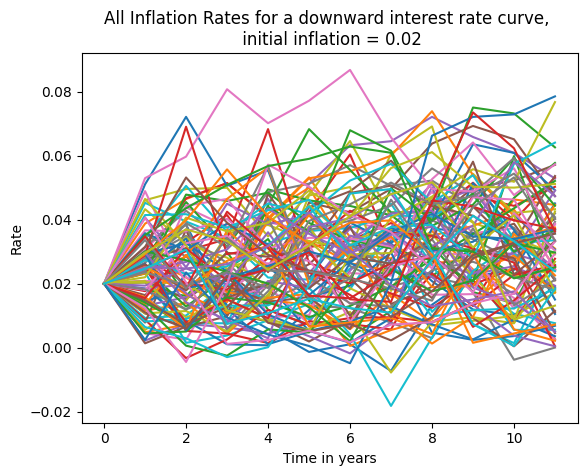

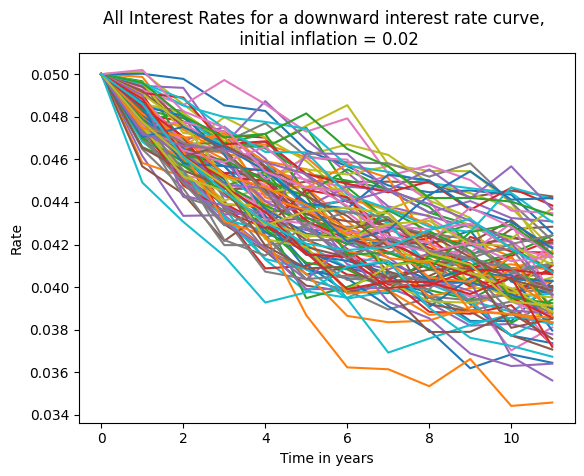

    inflationRate  interestRate    totalMoney  _id  tick               time   
0        0.020000      0.050000      0.000000    8     0  2018-01-01T00:00Z  \
1        0.035769      0.047888  20460.865752    8     1  2018-02-01T00:00Z   
2        0.030463      0.046498  19976.734393    8     2  2018-03-01T00:00Z   
3        0.038776      0.045682  20898.321007    8     3  2018-04-01T00:00Z   
4        0.032260      0.043679  20454.387513    8     4  2018-05-01T00:00Z   
..            ...           ...           ...  ...   ...                ...   
7        0.023928      0.038349  20737.276861    8     7  2018-08-01T00:00Z   
8        0.035025      0.038431  20217.297866    8     8  2018-09-01T00:00Z   
9        0.038007      0.039056  20302.465742    8     9  2018-10-01T00:00Z   
10       0.043147      0.039944  20409.522432    8    10  2018-11-01T00:00Z   
11       0.025099      0.038544 -11031.412884    8    11  2018-12-01T00:00Z   

                            Run_no  
0   downward_c

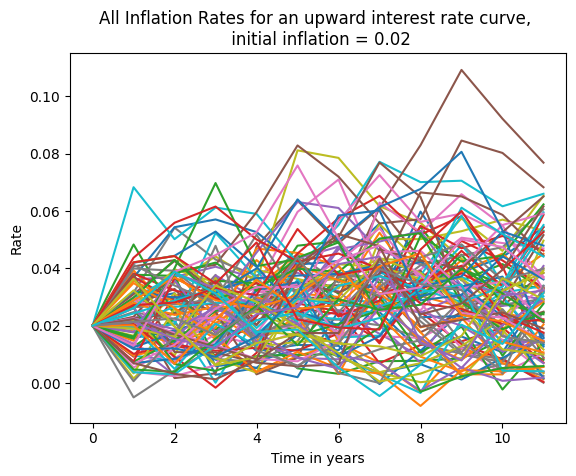

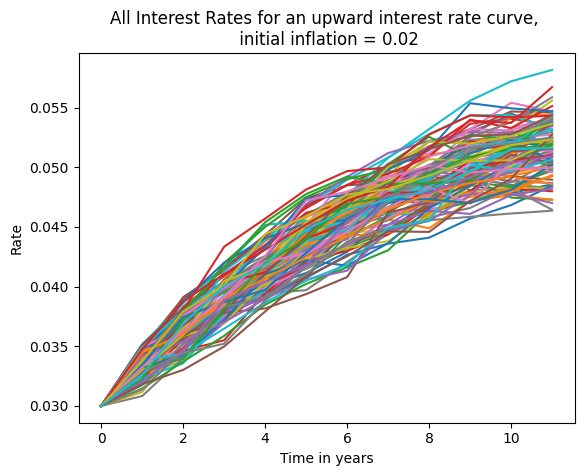

    inflationRate  interestRate    totalMoney  _id  tick               time   
0        0.020000      0.030000      0.000000    8     0  2018-01-01T00:00Z  \
1        0.020712      0.032564  21014.039308    8     1  2018-02-01T00:00Z   
2        0.009176      0.034616  20276.558373    8     2  2018-03-01T00:00Z   
3       -0.001591      0.035505  20157.458837    8     3  2018-04-01T00:00Z   
4        0.010542      0.039476  20993.324084    8     4  2018-05-01T00:00Z   
..            ...           ...           ...  ...   ...                ...   
7        0.020013      0.049903  22663.022837    8     7  2018-08-01T00:00Z   
8        0.007136      0.051768  20759.875817    8     8  2018-09-01T00:00Z   
9        0.012201      0.052987  20124.459283    8     9  2018-10-01T00:00Z   
10       0.014935      0.054276  19943.902377    8    10  2018-11-01T00:00Z   
11       0.014243      0.054732 -11129.990596    8    11  2018-12-01T00:00Z   

                          Run_no  
0   upward_comp0

In [21]:
def generate_bi_graphs(bi_df, title_description):
    grouped_bi = bi_df.groupby(["tick"])[["inflationRate", "interestRate"]].mean()
    print(grouped_bi.head())
    #grouped_bi.plot(legend=True)
    bi_df.groupby(["Run_no"])["inflationRate"].plot(title=("All Inflation Rates for " + title_description), ylabel="Rate", xlabel="Time in years")
    plt.show()
    bi_df.groupby(["Run_no"])["interestRate"].plot(title=("All Interest Rates for " + title_description), ylabel="Rate", xlabel="Time in years")
    plt.show()
    print(bi_df)

output_dir = "/home/sophie/Documents/uni/project/git_folder/saved_runs/"
run_seed = "0.02_value_rerun"
folder_name = "Simulation_Agent_BondIssuer"
absolute_path = output_dir + run_seed + "/" + folder_name
bi_df_up, bi_df_down = load_df(absolute_path)

generate_bi_graphs(bi_df_down, "a downward interest rate curve, \n initial inflation = " + run_seed.split("_")[0])
generate_bi_graphs(bi_df_up, "an upward interest rate curve, \n initial inflation = " + run_seed.split("_")[0])



Analyse Strategies when cap hit and when cap not hit

In [7]:
def only_capped(bi_df, pf_df, title):
    uncapped_runs = pd.unique(bi_df.loc[(bi_df["inflationRate"] < 0.05) & (bi_df["tick"] == 10) , "Run_no"])
    print(100-len(uncapped_runs))
    capped_pf_df = pf_df[~pf_df["Run_no"].isin(uncapped_runs)]
    uncapped_pf_df = pf_df[pf_df["Run_no"].isin(uncapped_runs)]
    plot_dif_bonds_graphs(capped_pf_df, (title + "\n with increasing inflation, initial inflation = " + run_seed.split("_")[0]), "increasing_infl") 
    # plot_summary_graphs(capped_pf_df[~capped_pf_df['isIndex'] ], (title + "\n with liability cap, initial inflation = " + run_seed.split("_")[0]))
    # plot_summary_graphs(capped_pf_df[capped_pf_df['isIndex'] ], (title + "\n with liability cap, initial inflation = " + run_seed.split("_")[0]))



In [8]:
def split_capped_uncapped(bi_df, pf_df, title):
    # uncapped_runs = pd.unique(bi_df.loc[(bi_df["inflationRate"] < 0.05) & (bi_df["tick"] == 11) , "Run_no"])
    capped_runs = pd.unique(bi_df.loc[(bi_df["inflationRate"] > 0.05) , "Run_no"])
    print(len(capped_runs))
    # print(bi_df.loc[(bi_df["inflationRate"] < 0.05) & (bi_df["tick"] == 11)])
    capped_pf_df = pf_df[pf_df["Run_no"].isin(capped_runs)]
    uncapped_pf_df = pf_df[~pf_df["Run_no"].isin(capped_runs)]
    plot_dif_bonds_graphs(capped_pf_df, (title + "\n with liability cap, initial inflation = " + run_seed.split("_")[0]), "all_capped") 
    plot_summary_graphs(capped_pf_df[~capped_pf_df['isIndex'] ], (title + "\n with liability cap, initial inflation = " + run_seed.split("_")[0]))
    plot_summary_graphs(capped_pf_df[capped_pf_df['isIndex'] ], (title + "\n with liability cap, initial inflation = " + run_seed.split("_")[0]))
    # print("uncapped graphs")
    # plot_summary_graphs(uncapped_pf_df, (title + " with uncapped liabilities"))
    # plot_dif_bonds_graphs(uncapped_pf_df, (title + "\n with liability cap, initial inflation = " + run_seed.split("_")[0]))



Generate All Graphs

b'/home/sophie/Documents/uni/project/git_folder/saved_runs/0.05_value_rerun/Simulation_Agent_PensionFund'
b'/home/sophie/Documents/uni/project/git_folder/saved_runs/0.05_value_rerun/Simulation_Agent_BondIssuer'
14
15
70


/home/sophie/miniconda3/envs/projectpython/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:509: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


76


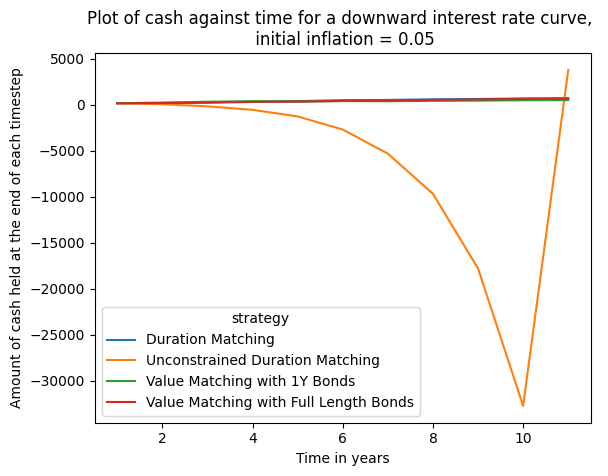

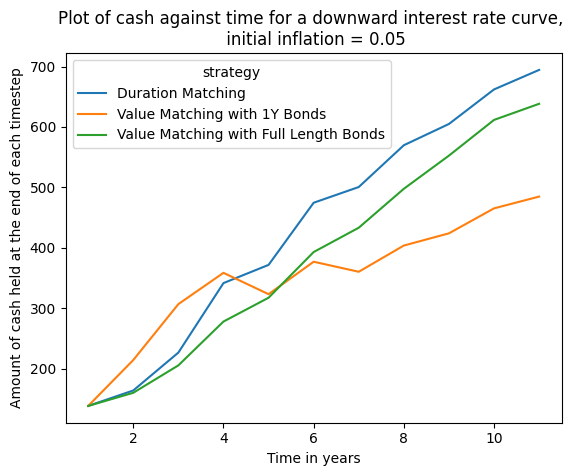

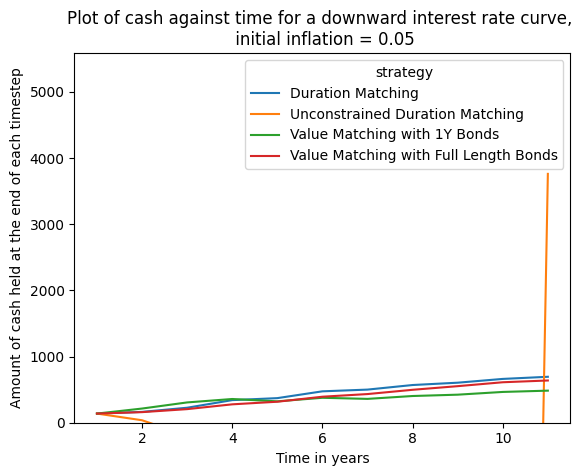

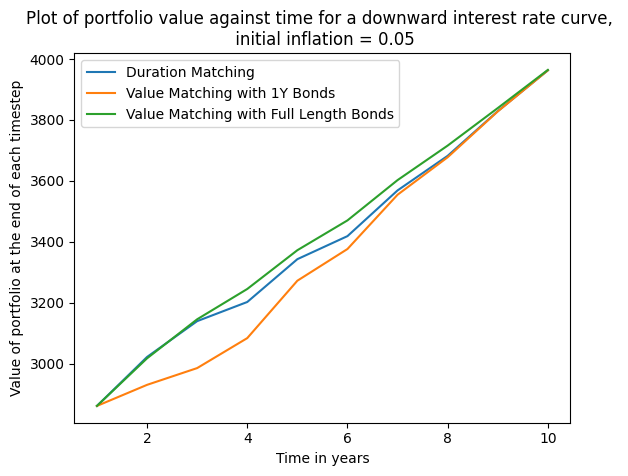

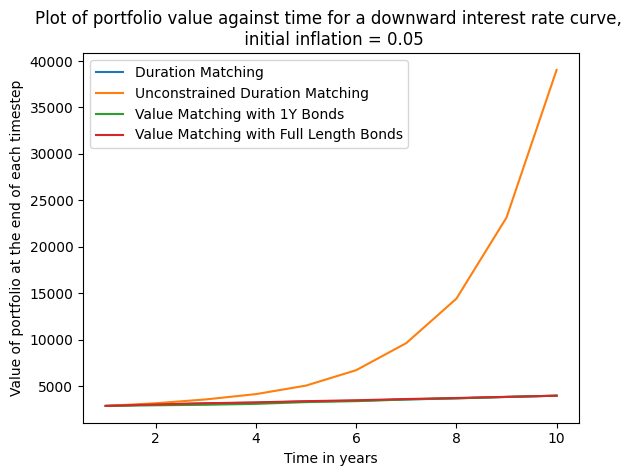

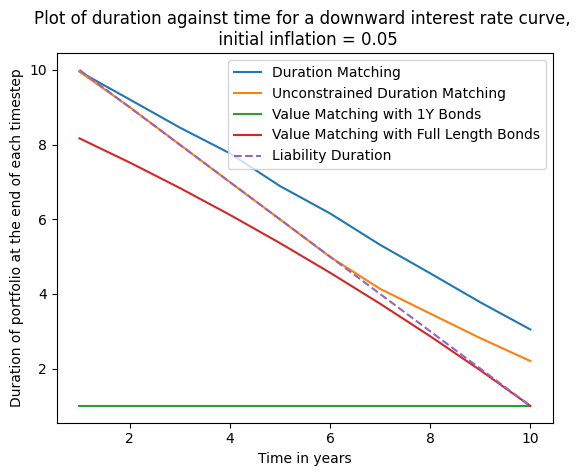

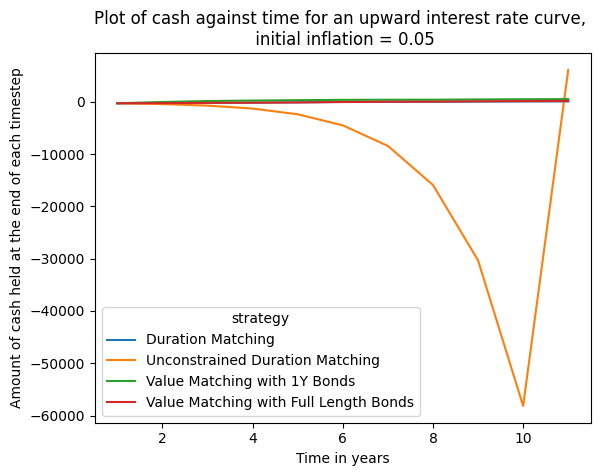

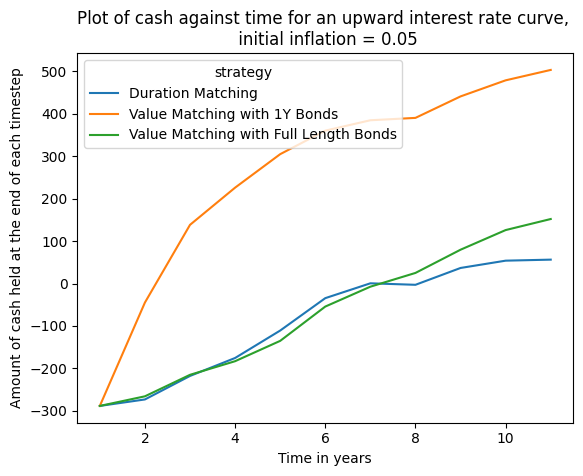

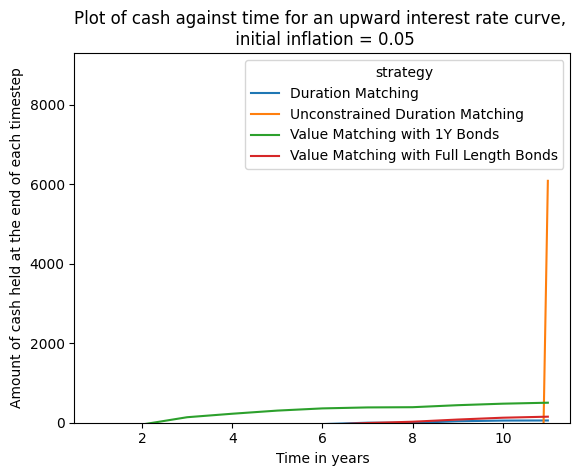

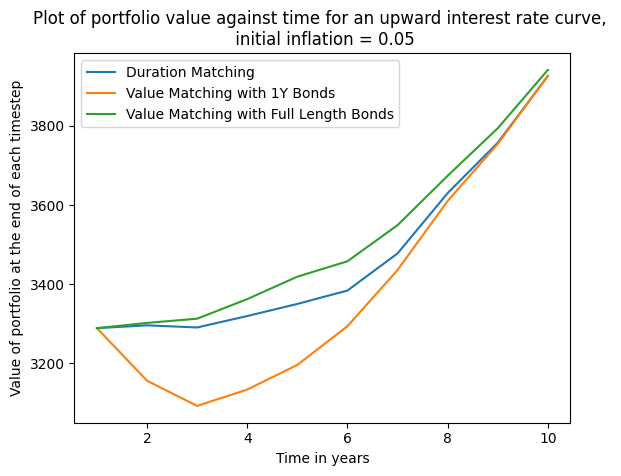

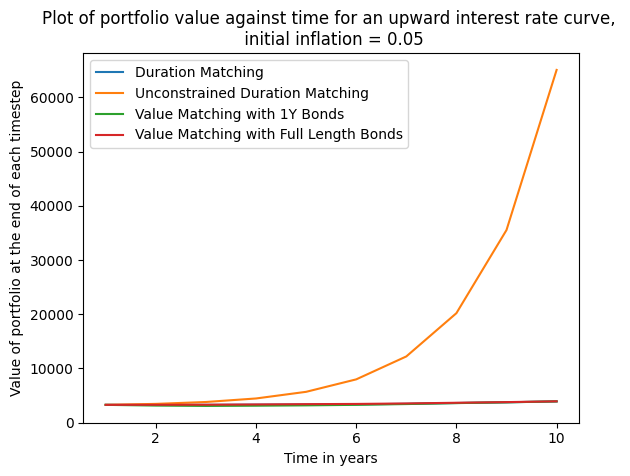

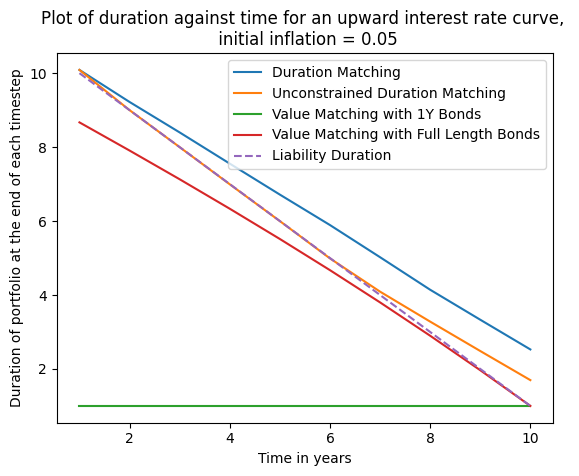

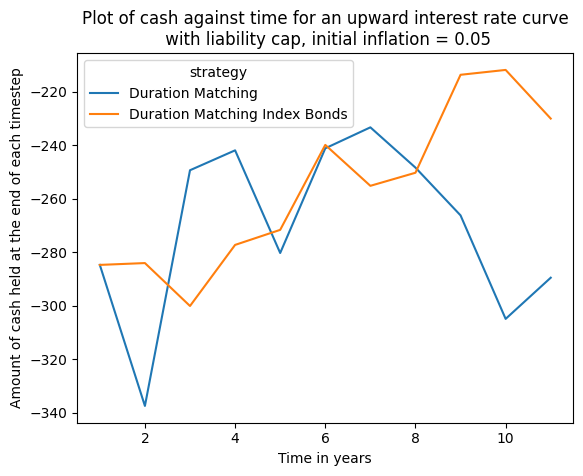

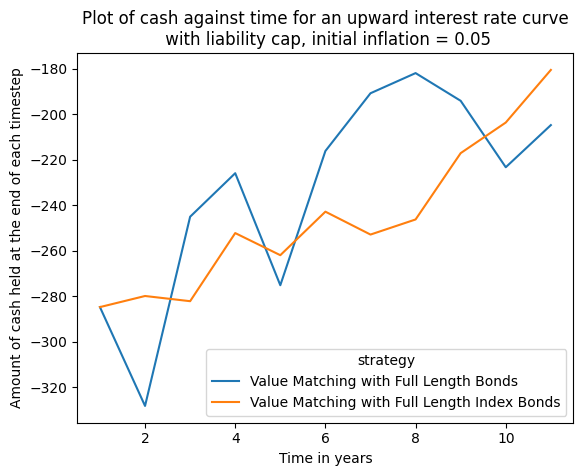

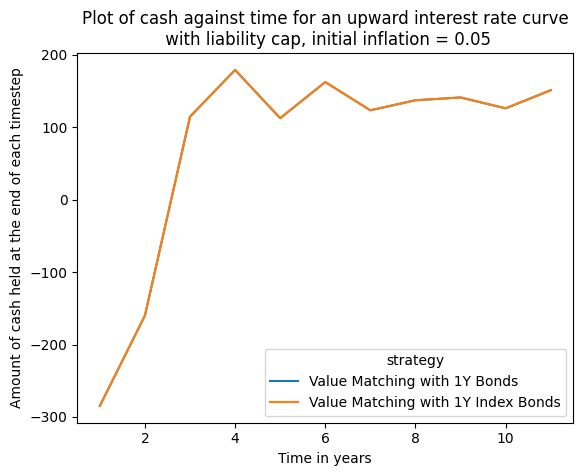

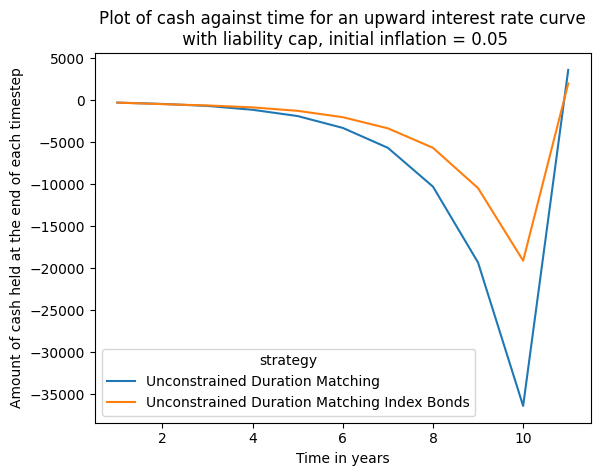

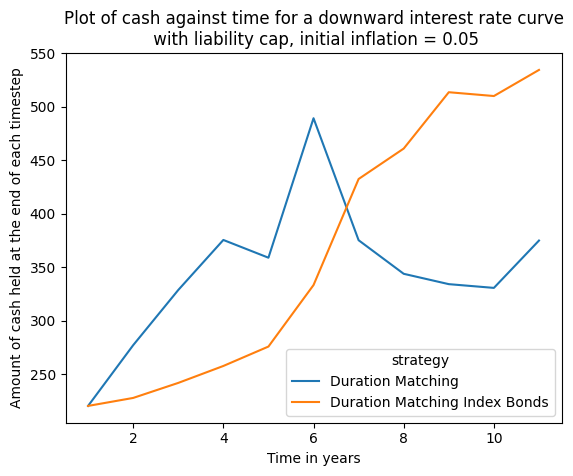

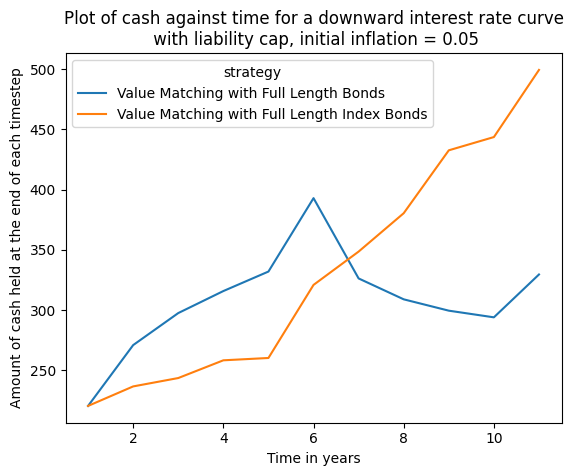

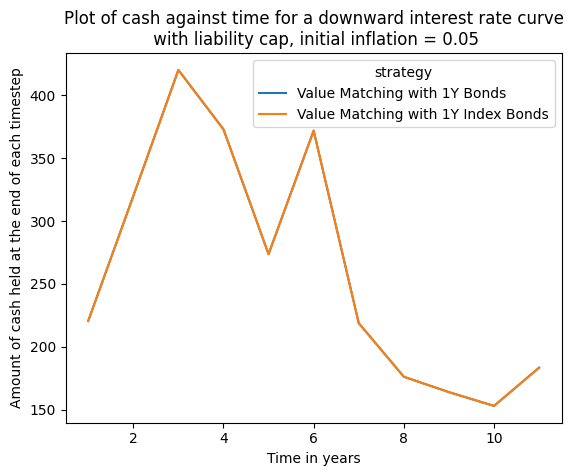

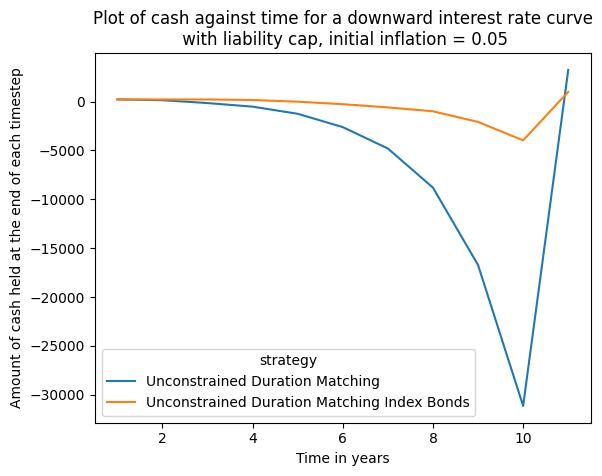

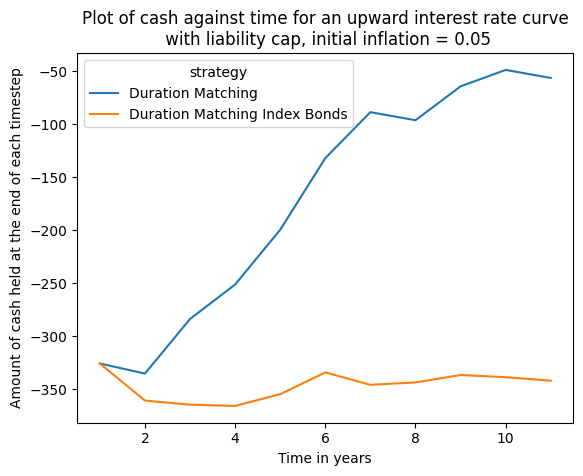

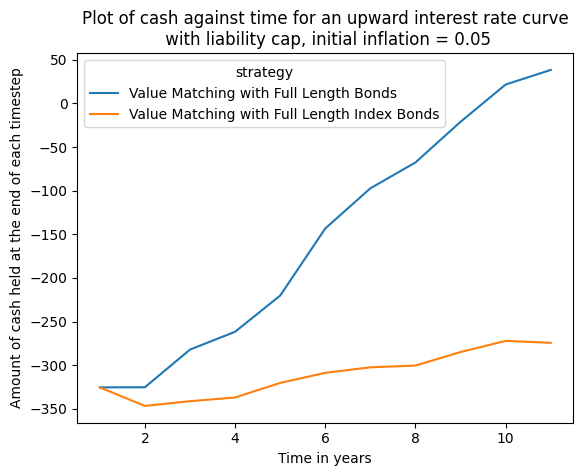

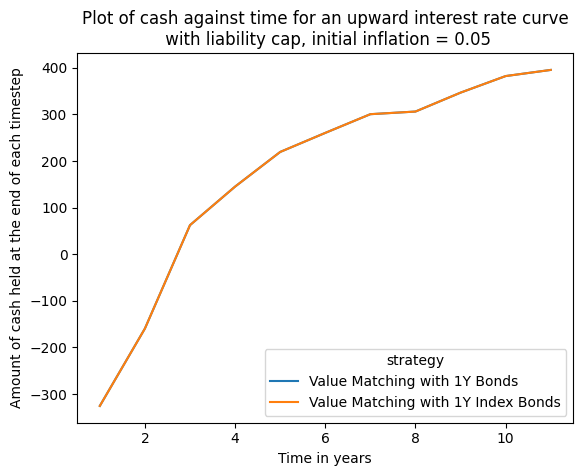

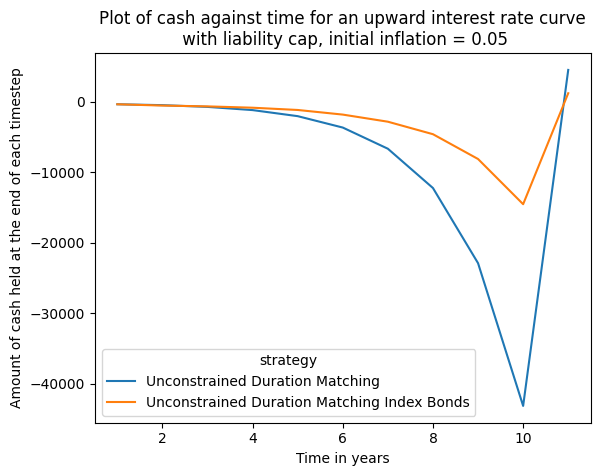

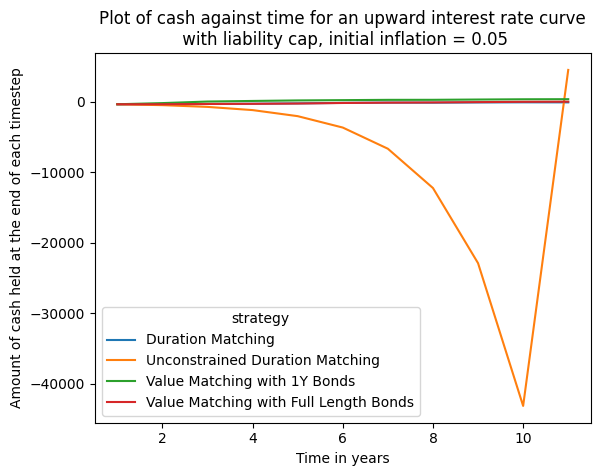

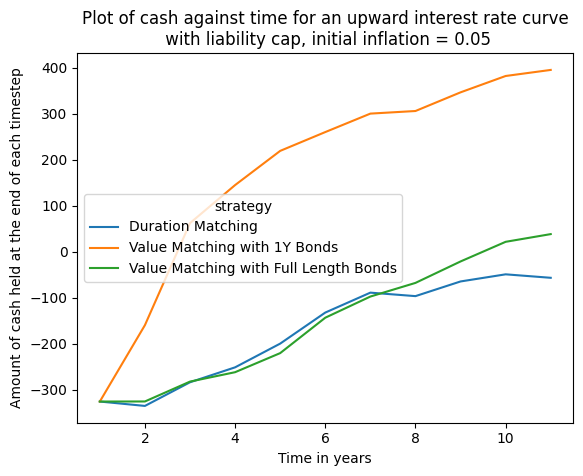

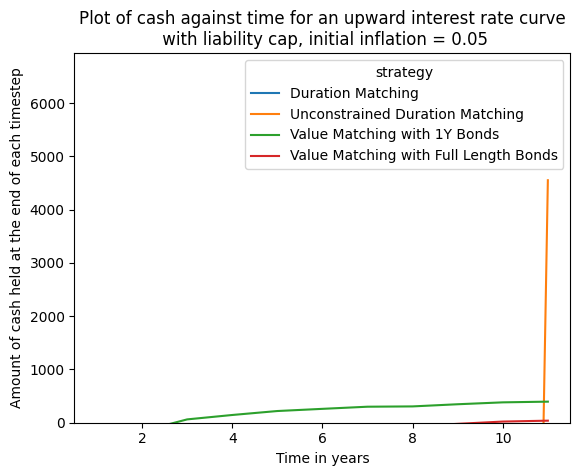

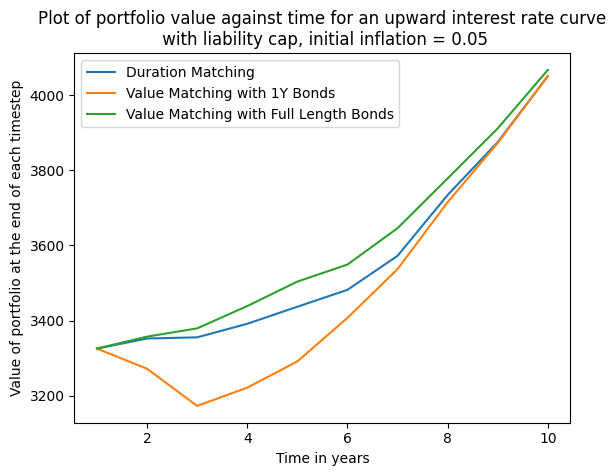

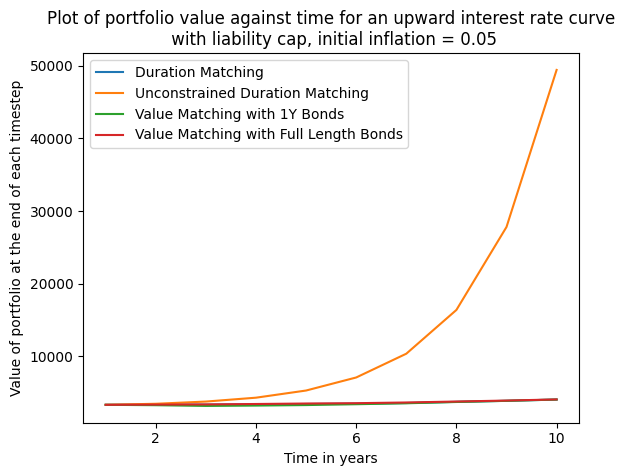

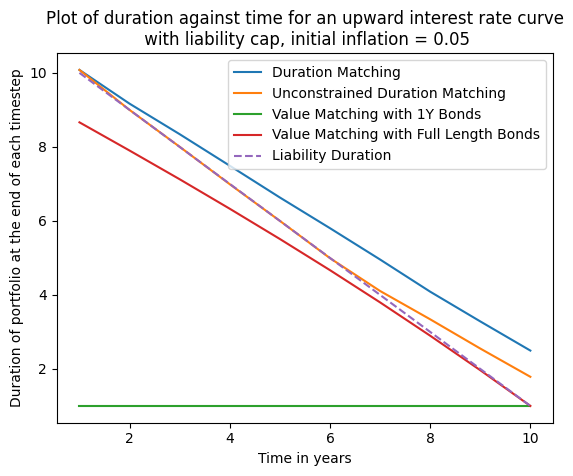

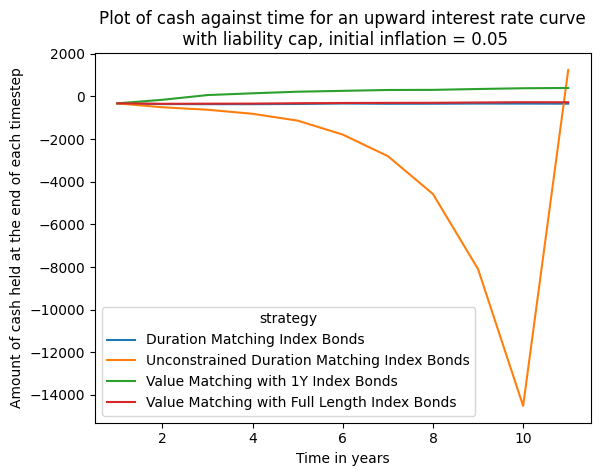

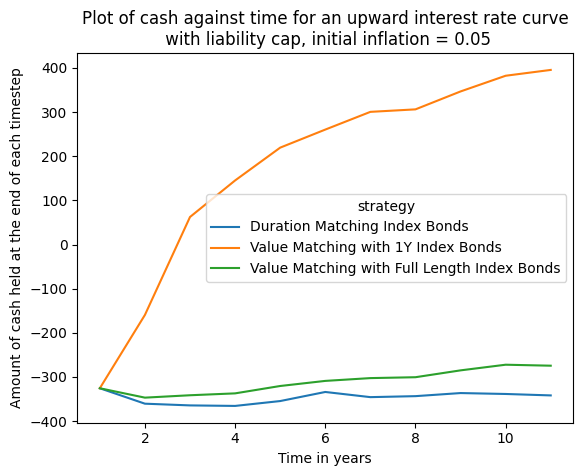

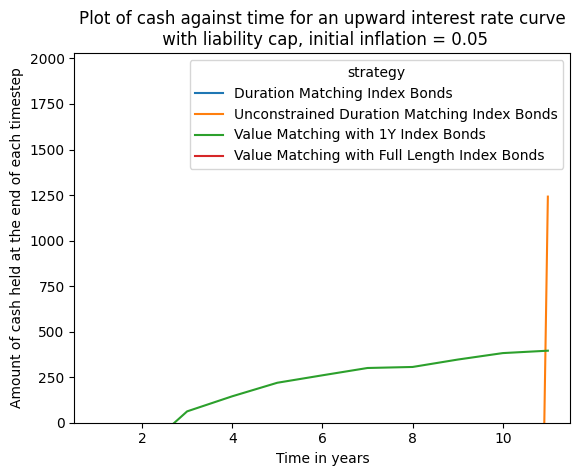

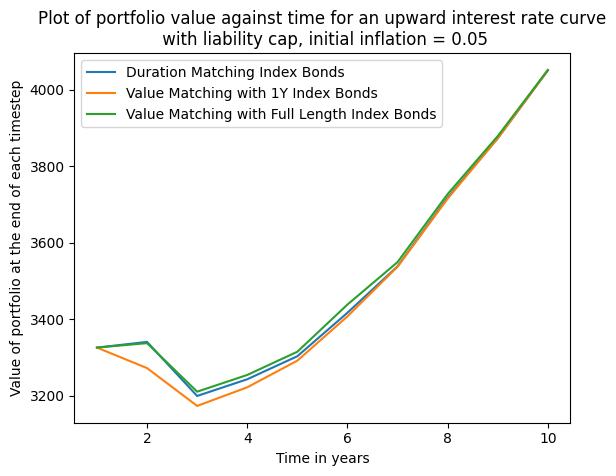

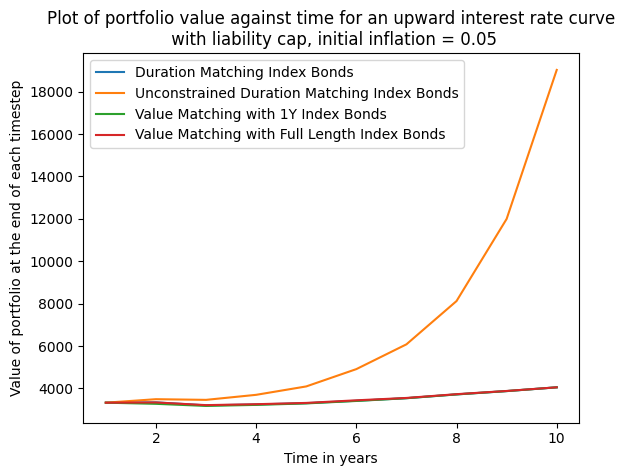

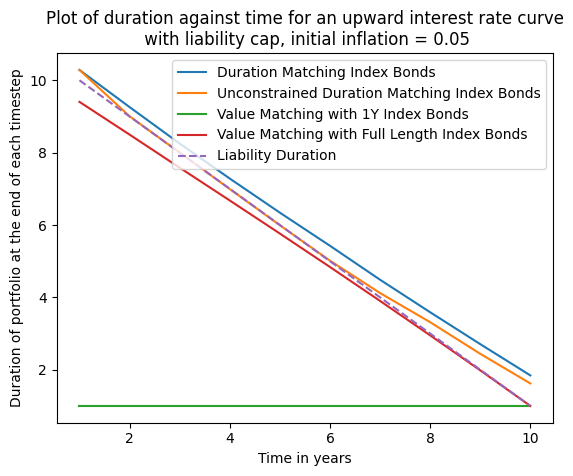

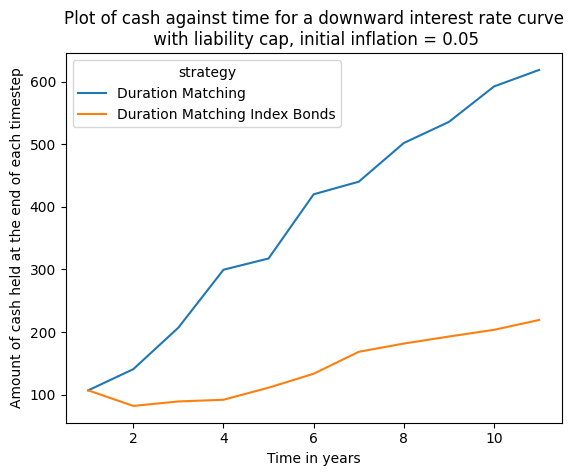

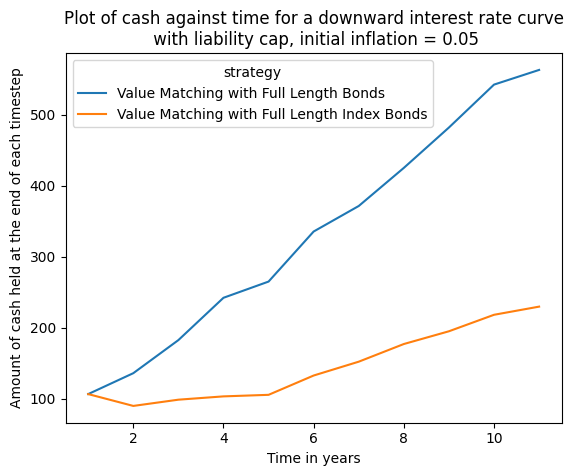

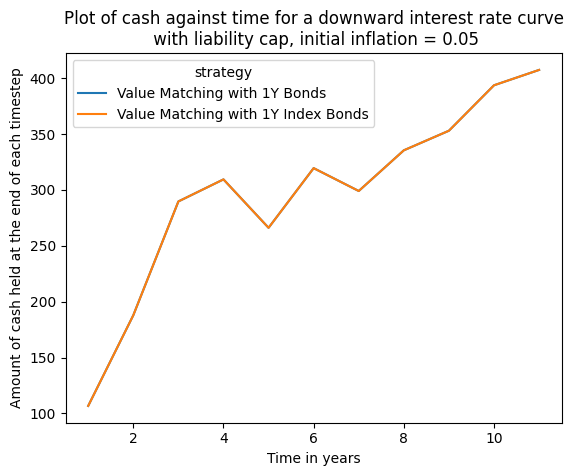

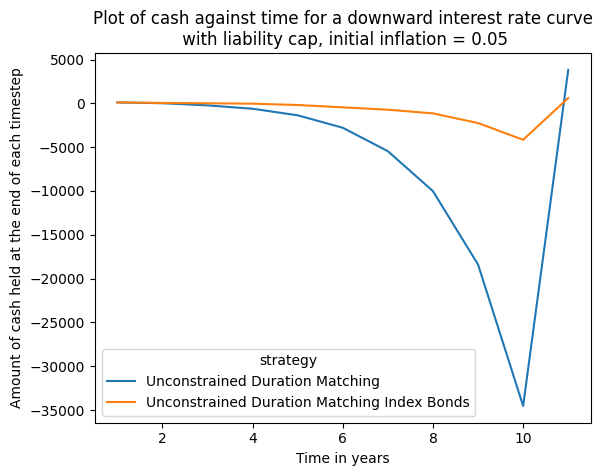

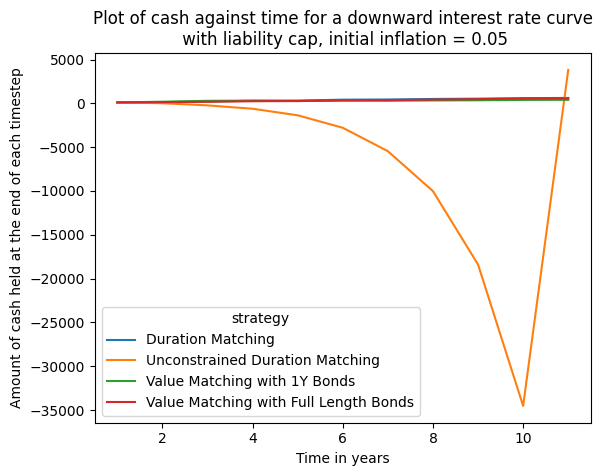

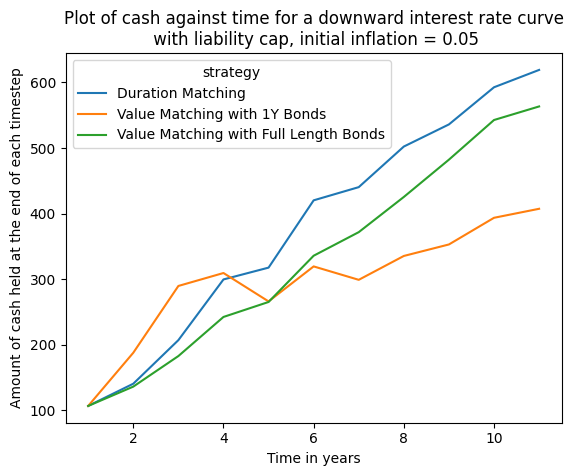

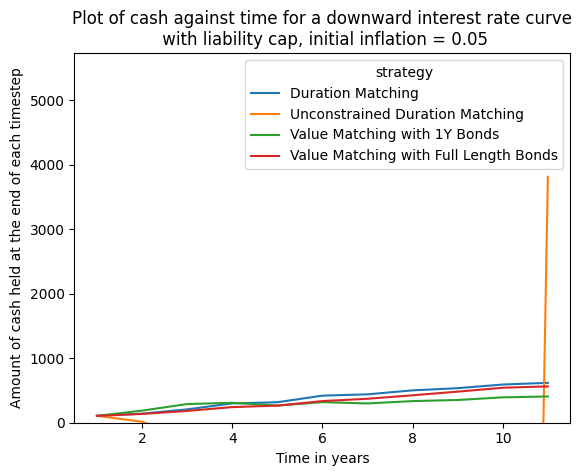

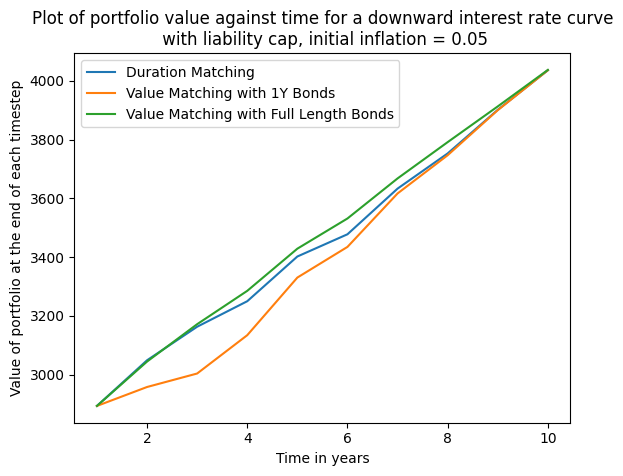

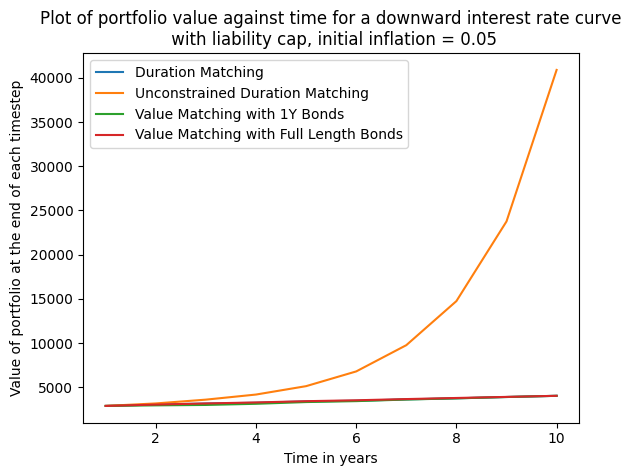

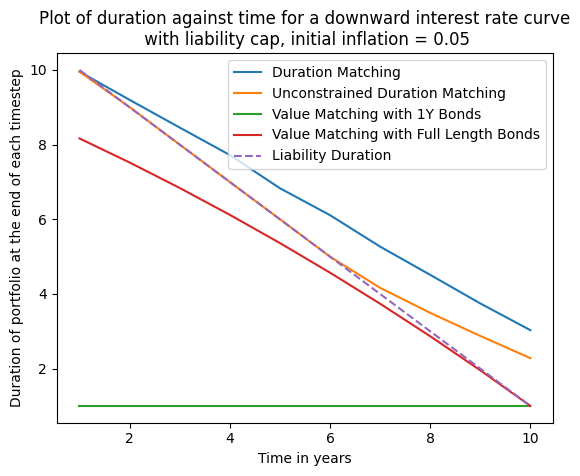

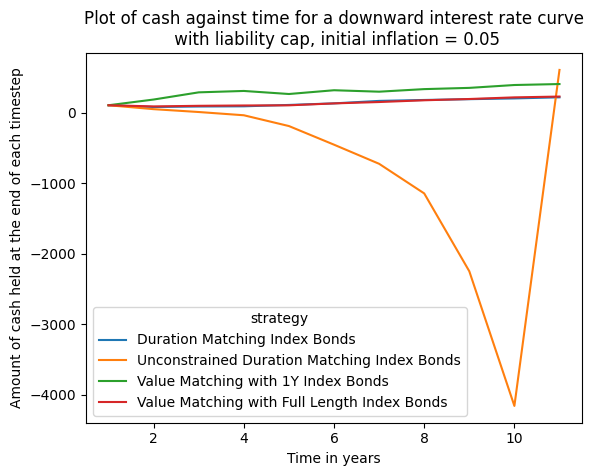

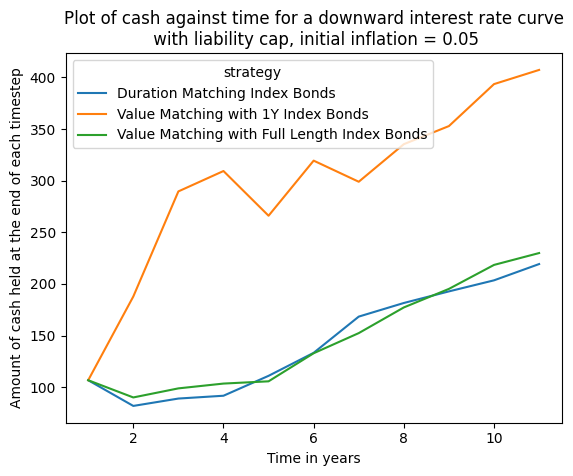

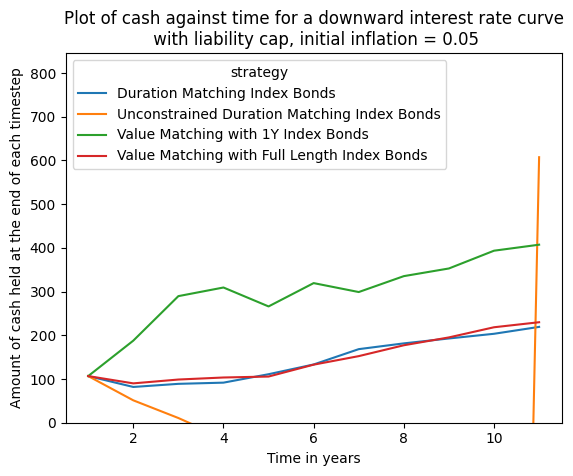

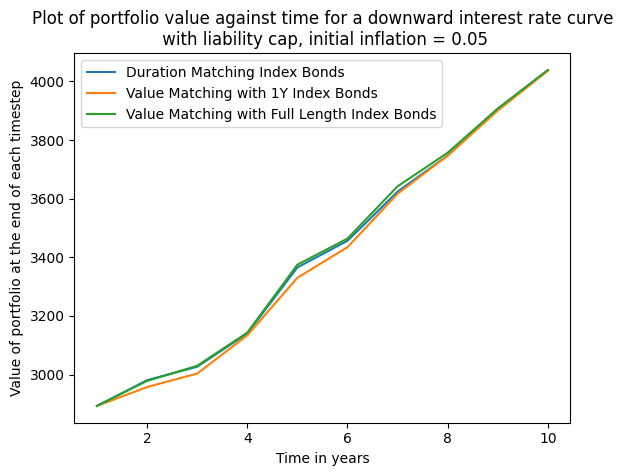

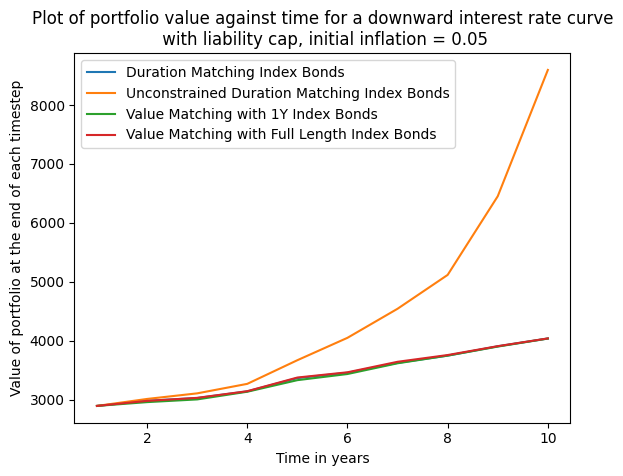

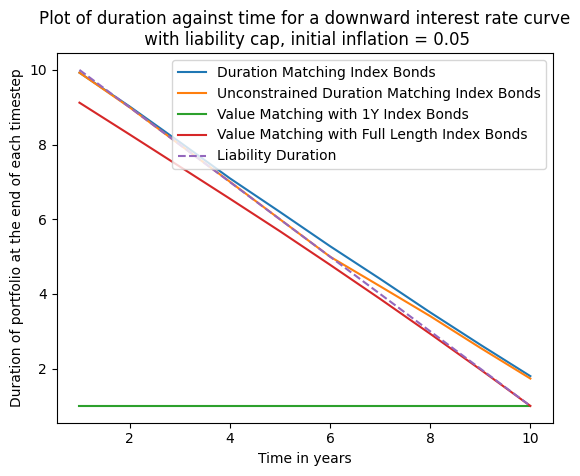

In [17]:
def graph_gen(pf_df_down, pf_df_up, high_infl, bi_df_down, bi_df_up):
    # Generates summary graphs for the non index linked cases
    plot_summary_graphs(pf_df_down[~pf_df_down['isIndex'] ], "a downward interest rate curve, \n initial inflation = " + run_seed.split("_")[0])
    plot_summary_graphs(pf_df_up[~pf_df_up['isIndex'] ], "an upward interest rate curve, \n initial inflation = " + run_seed.split("_")[0])
    

    if (high_infl):
        # Plots graphs comparing performance of index linked and non index linked on only the capped 
        only_capped(bi_df_up, pf_df_up, "an upward interest rate curve")
        only_capped(bi_df_down, pf_df_down, "a downward interest rate curve")

        split_capped_uncapped(bi_df_up, pf_df_up, "an upward interest rate curve")
        split_capped_uncapped(bi_df_down, pf_df_down, "a downward interest rate curve")
    else:
        plot_summary_graphs(pf_df_down[pf_df_down['isIndex'] ], "a downward interest rate curve, \n initial inflation = " + run_seed.split("_")[0])
        plot_summary_graphs(pf_df_up[pf_df_up['isIndex'] ], "an upward interest rate curve, \n initial inflation = " + run_seed.split("_")[0])
        plot_dif_bonds_graphs(pf_df_down,  "a downward interest rate curve,\n initial inflation = " + run_seed.split("_")[0], "")
        plot_dif_bonds_graphs(pf_df_up,  "an upward interest rate curve,\n initial inflation = " + run_seed.split("_")[0], "")


# output_dir = "/home/sophie/Documents/uni/project/git_folder/saved_runs/"
# run_seed = "0.02_value_rerun"
# folder_name = "Simulation_Agent_PensionFund"
# absolute_path = output_dir + run_seed + "/" + folder_name
# pf_df_up_low_infl, pf_df_down_low_infl = load_df(absolute_path)
# output_dir = "/home/sophie/Documents/uni/project/git_folder/saved_runs/"
# folder_name = "Simulation_Agent_BondIssuer"
# absolute_path = output_dir + run_seed + "/" + folder_name
# bi_df_up_low_infl, bi_df_down_low_infl = load_df(absolute_path)

# graph_gen(pf_df_down_low_infl, pf_df_up_low_infl, False, bi_df_up_low_infl, bi_df_down_low_infl)

output_dir = "/home/sophie/Documents/uni/project/git_folder/saved_runs/"
run_seed = "0.05_value_rerun"
folder_name = "Simulation_Agent_PensionFund"
absolute_path = output_dir + run_seed + "/" + folder_name
pf_df_up_high_infl, pf_df_down_high_infl = load_df(absolute_path)
output_dir = "/home/sophie/Documents/uni/project/git_folder/saved_runs/"
folder_name = "Simulation_Agent_BondIssuer"
absolute_path = output_dir + run_seed + "/" + folder_name
bi_df_up_high_infl, bi_df_down_high_infl = load_df(absolute_path)

graph_gen(pf_df_down_high_infl, pf_df_up_high_infl, True, bi_df_down_high_infl, bi_df_up_high_infl)

